In [655]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [656]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('ggplot')
%matplotlib inline

from datetime import *

import os
import holidays

pd.set_option("display.max_colwidth",200)
pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)

In [657]:
from feature_importance import *
from helper import *

## Load Data

In [674]:
def add_reviews_cnt(listings, reviews):
    last30 = listings.last_scraped[0] - timedelta(30)
    last60 = listings.last_scraped[0] - timedelta(60)
    last90 = listings.last_scraped[0] - timedelta(90)
    last120 = listings.last_scraped[0] - timedelta(120)
    last180 = listings.last_scraped[0] - timedelta(180)
    
    reviewslast30days = reviews[reviews.date>last30].groupby('listing_id').count()
    reviewslast60days = reviews[reviews.date>last60].groupby('listing_id').count()
    reviewslast90days = reviews[reviews.date>last90].groupby('listing_id').count()
    reviewslast120days = reviews[reviews.date>last120].groupby('listing_id').count()
    reviewslast180days = reviews[reviews.date>last180].groupby('listing_id').count()
    
    reviews_count = pd.concat([reviewslast30days,reviewslast60days,
                               reviewslast90days,reviewslast120days,
                              reviewslast180days],axis=1).fillna(0)
    reviews_count.columns=['last30','last60','last90','last120','last180']
    listings = pd.merge(listings, reviews_count,how='left', left_on='id', right_index=True)
    return listings

In [675]:
columns = ['id','price','availability_30','availability_60','reviews_per_month',
'number_of_reviews','last_review','calendar_updated','host_since','minimum_nights',
'room_type','host_response_time', 'host_is_superhost',
'review_scores_rating','property_type', 
'neighbourhood_cleansed','bedrooms',
'calculated_host_listings_count','host_identity_verified',
'cleaning_fee','last_scraped',
'latitude','longitude','beds','cancellation_policy','access',
'require_guest_phone_verification','description','notes','transit',
'instant_bookable','extra_people','maximum_nights','house_rules',
]

In [676]:
listings = pd.read_csv('data/listings20180509.csv',usecols=columns,parse_dates=['last_scraped'])
reviews = pd.read_csv('data/reviews/reviews20180509.csv',parse_dates=['date'])
listings = add_reviews_cnt(listings, reviews)

path = os.getcwd()
folder_path = path + '/data/'
for file_name_listing in os.listdir(folder_path):
    if file_name_listing.endswith('.csv') and file_name_listing != 'listings20180509.csv':
        path=folder_path+file_name_listing
        date_part = file_name_listing[-12:-4]
        temp = pd.read_csv(path,usecols=columns,parse_dates=['last_scraped'])
        for file_name_review in os.listdir(folder_path + 'reviews/'):
            if file_name_review == 'reviews{}.csv'.format(date_part):
                path_review = folder_path +  'reviews/' + file_name_review
                reviews = pd.read_csv(path_review,parse_dates=['date'])
                temp = add_reviews_cnt(temp, reviews)
                print('reviews{}.csv'.format(date_part))
        listings = pd.concat([listings, temp])
        print(listings.shape)

reviews20170802.csv
(13831, 39)
reviews20180110.csv
(20337, 39)
reviews20180304.csv
(25141, 39)
reviews20171101.csv
(34070, 39)
reviews20180202.csv
(38797, 39)
reviews20180406.csv
(43641, 39)
reviews20171202.csv
(50581, 39)
reviews20170902.csv
(59110, 39)
reviews20171002.csv
(68043, 39)
reviews20170702.csv
(76898, 39)
reviews20170602.csv
(85697, 39)


In [677]:
listings[['last30','last60','last90','last120','last180']] = listings[['last30','last60','last90','last120','last180']].fillna(0, axis=1)

In [678]:
listings['last_review'] = pd.to_datetime(listings['last_review'])
listings['last_scraped'] = pd.to_datetime(listings['last_scraped'])
listings['host_since'] = pd.to_datetime(listings['host_since'])

In [916]:
df_listings = listings.copy()
df_listings.shape

(85697, 39)

## Use only short term rental listings - minimum_nights <= 7

In [1378]:
df_listings = listings.copy()


df_listings = df_listings[df_listings.minimum_nights<=7]
total = df_listings.shape[0] 
print(df_listings.shape[0]/listings.shape[0])
print(df_listings.shape)

0.8946054120914384
(76665, 39)


check listings whose available days equals to zero for th next 30 days

- condition 1: at least 1 review last month
- condition 2: average monthly review needs to be higher than 1

In [1379]:
df_listings = df_listings[df_listings.reviews_per_month>0]
total = df_listings.shape[0] 
print(df_listings.shape[0]/listings.shape[0])
print(df_listings.shape)


0.7443201045544184
(63786, 39)


In [1380]:
def select_active_host(df_listings, nb_availability, nb_reviews, my_condition):
    mask_check_list = (df_listings['availability_30']==nb_availability)
    listings_to_check = df_listings[mask_check_list]
    listings_left = df_listings[~mask_check_list]
    
    print('{} of listings to check'.format(listings_to_check.shape[0]))
    
    condition = listings_to_check[my_condition]>=nb_reviews
    listings_to_keep = listings_to_check[condition]
    
    lost = listings_to_check.shape[0] - listings_to_keep.shape[0]
    pct = lost / listings_to_check.shape[0] * 100
    pct_total = lost / total
    print('Lost {} listings. About {:.2f}% of listings to check and {:.2f}% of total. \n'.format(lost, pct, pct_total))
    return pd.concat([listings_left,listings_to_keep])

In [1381]:
# for available, nb_reviews,my_condition in zip(range(30),[1]*30,['last180']*30):
#     df_listings = select_active_host(df_listings, available, nb_reviews,my_condition )

In [1382]:
pair_available_nb_reviews = [(0,12, 'last60'),(1,11,'last60'),(2,11,'last60'), (3,10,'last60'), (4,9, 'last60'),
                            (5,8, 'last60'),(6,7,'last60'),(7,6,'last60'), (8,5,'last60'), (9,4, 'last60'),
                            (10,3, 'last90'),(11,2, 'last90'),(12,2, 'last90'),(13,1, 'last90'),(14,1, 'last90'),
                            (15,1, 'last90')]
                          
for available, nb_reviews,my_condition in pair_available_nb_reviews:
    df_listings = select_active_host(df_listings, available, nb_reviews,my_condition )

23472 of listings to check
Lost 23146 listings. About 98.61% of listings to check and 0.36% of total. 

2432 of listings to check
Lost 2119 listings. About 87.13% of listings to check and 0.03% of total. 

2461 of listings to check
Lost 2057 listings. About 83.58% of listings to check and 0.03% of total. 

2469 of listings to check
Lost 1949 listings. About 78.94% of listings to check and 0.03% of total. 

2451 of listings to check
Lost 1842 listings. About 75.15% of listings to check and 0.03% of total. 

2262 of listings to check
Lost 1511 listings. About 66.80% of listings to check and 0.02% of total. 

2150 of listings to check
Lost 1331 listings. About 61.91% of listings to check and 0.02% of total. 

1960 of listings to check
Lost 1070 listings. About 54.59% of listings to check and 0.02% of total. 

1947 of listings to check
Lost 968 listings. About 49.72% of listings to check and 0.02% of total. 

1664 of listings to check
Lost 676 listings. About 40.62% of listings to check an

In [1383]:
print(df_listings.shape)
print(df_listings.id.nunique())
listings_used = df_listings.copy()

(25972, 39)
5666


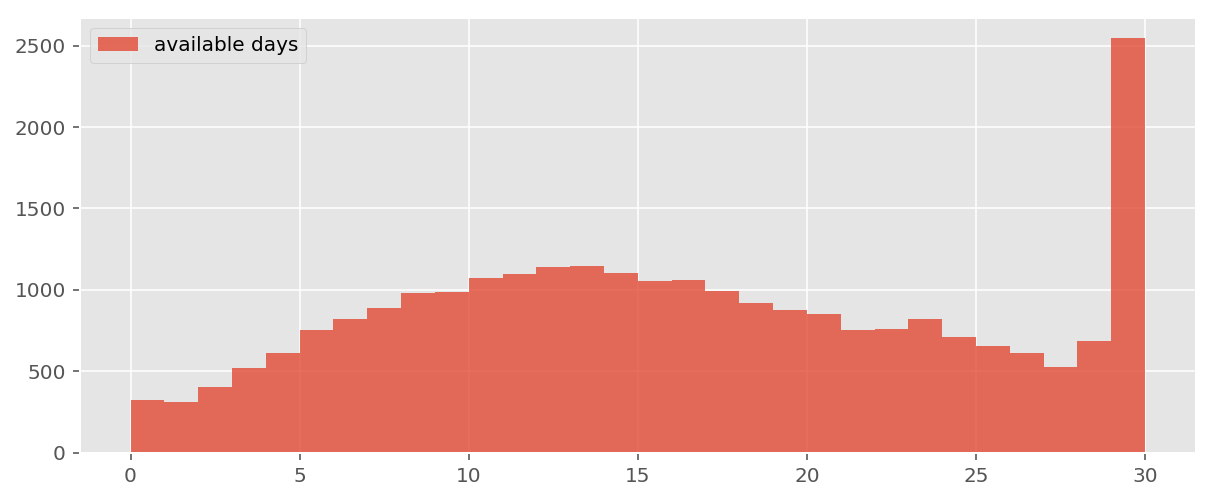

In [1384]:
fig, ax1 = plt.subplots(1,1,figsize=(10,4))
ax1.hist(listings_used.availability_30.values, bins=30, label='available days',alpha=.8)
ax1.legend();

In [1385]:
listings_used['Occupancy_level_1st_month'] = pd.cut(listings_used.availability_30,
                                           bins=[0,10,20,31],labels=['low','medium','high'], right=False)
df_low = listings_used[listings_used['Occupancy_level_1st_month'] == 'low']
df_medium = listings_used[listings_used['Occupancy_level_1st_month'] == 'medium']
df_high = listings_used[listings_used['Occupancy_level_1st_month'] == 'high']

In [1250]:
def create_data_source(data_frame):
    return ColumnDataSource(
        data=dict(
        price = data_frame['price'],
        bedrooms=data_frame['bedrooms'],
        room_type=data_frame['room_type'],
        property_type=data_frame['property_type'],
        neighbourhood_cleansed=data_frame['neighbourhood_cleansed'],
        availability_30 = data_frame['availability_30'],
        lat=data_frame['latitude'],
        lon=data_frame['longitude'],
        ))

In [1386]:
from bokeh.plotting import ColumnDataSource,output_file, gmap
from bokeh.models import (HoverTool,GMapPlot,GMapOptions,DataRange1d,
                          glyphs)
from bokeh.io import push_notebook, show, output_notebook
# from bokeh.resources import CDN
output_notebook()

Loading BokehJS ...

In [1387]:
map_options = GMapOptions(lat=37.762835, lng=-122.434239, map_type="roadmap", zoom=12)
plot = gmap("keys", map_options,
            title="Next 30 days availability: Blue - Low | Magenta - Medium | Red - High ")
for df, color in zip([df_low, df_medium, df_high], ['blue','green','red']):
    source = create_data_source(df)
    circle_m = glyphs.Circle(x="lon", y="lat",size=3, line_color=color, fill_color=color,line_alpha=0.1, fill_alpha=0.1)
    cpm = plot.add_glyph(source,circle_m)

plot.add_tools(HoverTool(tooltips = [('price', '@price'),
                                     ('bedrooms','@bedrooms'),
                                     ('room_type','@room_type'),
                                     ('property_type','@property_type'),
                                     ('neighbourhood_cleansed','@neighbourhood_cleansed'),
                                     ('availability 30 days','@availability_30'),
                                     ]))
show(plot)

In [1388]:
listings_used.shape

(25972, 40)

In [1389]:
listings_final = listings_used.copy()

In [1390]:
listings_final.drop(['last_review','Occupancy_level_1st_month',
                     'availability_60','last30','last60', 'last90',
                     'last120','last180'], axis=1, inplace=True)

In [1391]:
# Clean price label: remove the dollar sign and comma.
listings_final.price=listings_final.price.str.replace(r'[$,]','').astype(float)
listings_final.cleaning_fee=listings_final.cleaning_fee.str.replace(r'[$,]','').astype(float)
listings_final.extra_people=listings_final.extra_people.str.replace(r'[$,]','').astype(float)

In [1392]:
# deal with nan
listings_final.cleaning_fee = listings_final.cleaning_fee.fillna(0)
listings_final.reviews_per_month = listings_final.reviews_per_month.fillna(0)
listings_final.review_scores_rating = listings_final.review_scores_rating.fillna(0)
listings_final.beds = listings_final.beds.fillna(1)
listings_final.host_response_time = listings_final.host_response_time.fillna('unknown')

In [1393]:
# transform t/f column to 1 and 0
columns_t_f = ['host_is_superhost','instant_bookable',
               'host_identity_verified',
               'require_guest_phone_verification']
listings_final[columns_t_f] = listings_final[columns_t_f].replace({'f':0,'t':1})

In [1394]:
listings_final.loc[listings_final['bedrooms']==0,'bedrooms'] = 1
listings_final.loc[listings_final['beds']==0,'beds'] = 1

In [1395]:
listings_final.head(1)

,id,last_scraped,description,notes,transit,access,house_rules,host_since,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,bedrooms,beds,price,cleaning_fee,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
5,8339,2018-05-09,"Pls email before booking. Interior featured in magazines. Listed historic with the City of SF. Steps away from the iconic Alamo Square ""Painted Ladies"". European feel, reminiscent of the Boutique...",tax ID on file tax ID on file,NaN,Guests have access to everything listed and shown.,"House Manual and House Rules will be provided after initial communication, when we work out that the exact timing and use are suitable for both parties House Manual and House Rules will be provide...",2009-07-02,within a few hours,0.0,1.0,Western Addition,37.775249,-122.436374,House,Entire home/apt,2.0,2.0,575.0,150.0,150.0,5,1125,3 months ago,30,26,97.0,0,strict_14_with_grace_period,1,2,0.25


In [1396]:
# Feature engineering - month
listings_final['predict_month'] =  listings_final['last_scraped'].dt.month.astype(str)

In [1397]:
# Feature engineering - total_hosting_days, price_per_bedroom, price_per_bed
listings_final['total_hosting_days']=listings_final['last_scraped'] - listings_final['host_since']
listings_final['total_hosting_days']=listings_final['total_hosting_days'].apply(lambda row: row.days)
listings_final['price_per_bedroom']=listings_final['price']/listings_final['bedrooms']
listings_final['price_per_bed']=listings_final['price']/listings_final['beds']

In [1398]:
# Feature engineering - neighbourhood_mean_price, neighbourhood_mean_price_per_bedroom,
# price_diff_mean_neighbourhood, price_per_bedroom_diff_mean_neighbourhood
df_price_neighbourhood = listings_final.groupby('neighbourhood_cleansed')[['price_per_bedroom','price']].mean()
df_price_neighbourhood.columns=['neighbourhood_mean_price_per_bedroom','neighbourhood_mean_price']
listings_final = pd.merge(listings_final,df_price_neighbourhood,how='left',
         left_on='neighbourhood_cleansed',right_index=True)

listings_final['price_diff_mean_neighbourhood'] = listings_final['price'] - listings_final['neighbourhood_mean_price']
listings_final['price_per_bedroom_diff_mean_neighbourhood'] = listings_final['price_per_bedroom'] - listings_final['neighbourhood_mean_price_per_bedroom']

In [1399]:
# Feature engineering - len_house_rules, len_access, len_transit, len_description
listings_final['len_house_rules'] = listings_final['house_rules'].astype(str).apply(lambda x: len(x.split(' ')))
listings_final['len_description'] = listings_final['description'].astype(str).apply(lambda x: len(x.split(' ')))
listings_final['len_access'] = listings_final['access'].astype(str).apply(lambda x: len(x.split(' ')))
listings_final['len_transit'] = listings_final['transit'].astype(str).apply(lambda x: len(x.split(' ')))

In [1400]:
holidays = pd.read_csv('holidays.csv', header=None)
holidays.columns=['date','holidays']
holidays.date = pd.to_datetime(holidays.date)

In [1401]:
def add_holidays(x, df_holidays):
    t1 = x 
    t2 = x + timedelta(30)
    for idx in range(df_holidays.shape[0]):
        if df_holidays.iloc[idx,0] >= t1 and df_holidays.iloc[idx,0]<t2:
            return df_holidays.iloc[idx,1]
    
    return 'No_holiday'

In [1402]:
listings_final['holiday'] = listings_final['last_scraped'].apply(
    lambda x: add_holidays(x, holidays))

In [1403]:
listings_final.drop(['last_scraped','host_since','number_of_reviews',
                     'reviews_per_month','id','notes','access',
                     'house_rules','description','transit'], axis=1, inplace=True)

In [1404]:
report_nan(listings_final).iloc[:10,:]

,Total,Percent
host_is_superhost,44,0.169413
host_identity_verified,44,0.169413
total_hosting_days,44,0.169413
bedrooms,14,0.053904
price_per_bedroom_diff_mean_neighbourhood,14,0.053904
price_per_bedroom,14,0.053904
holiday,0,0.000000
minimum_nights,0,0.000000
extra_people,0,0.000000
cleaning_fee,0,0.000000


In [1405]:
listings_final.dropna(inplace=True)

In [1406]:
report_nan(listings_final).iloc[:10,:]

,Total,Percent
holiday,0,0.0
bedrooms,0,0.0
maximum_nights,0,0.0
minimum_nights,0,0.0
extra_people,0,0.0
cleaning_fee,0,0.0
price,0,0.0
beds,0,0.0
room_type,0,0.0
availability_30,0,0.0


In [1407]:
# dummify categorical variables
listings_final = pd.get_dummies(listings_final)

In [1408]:
# Creat label
y = listings_final.pop('availability_30')

In [1409]:
X = listings_final

In [1410]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [1411]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
# from sklearn.model_selection import cross_val_score

In [1412]:
rf = RandomForestRegressor(n_estimators=50)
m = rf.fit(X_train,np.log(y_train+1))
y_pred = np.clip(np.exp(m.predict(X_test))-1, 0, 30)

In [1413]:
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_log_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

4.55674453886
0.209542892736
34.3134294791


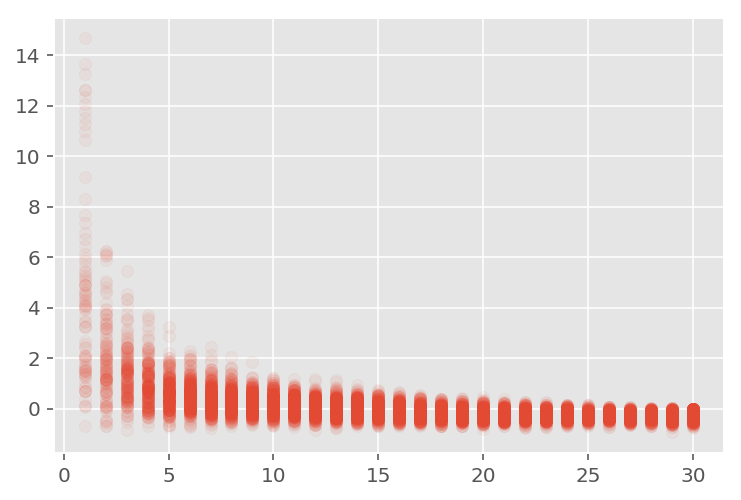

In [1414]:
plt.scatter(y_test, (y_pred-y_test)/y_test, alpha=0.05);

In [1415]:
(y_test).mean()*0.40

6.408933582787653

In [1416]:
abs(((y_pred+1)-(y_test+1))/(y_test+1)).mean()

0.4106649224553926

In [1417]:
rf = RandomForestRegressor(n_estimators=50)
m = rf.fit(X_train,y_train)
y_pred = np.clip(np.round(m.predict(X_test)), 0, 30)

In [1418]:
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_log_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

4.513797942
0.226964422504
32.2464920486


`4.41679890234
0.200529915513
32.0959029175`

`4.35370179654
0.21774572576
30.2024259069`

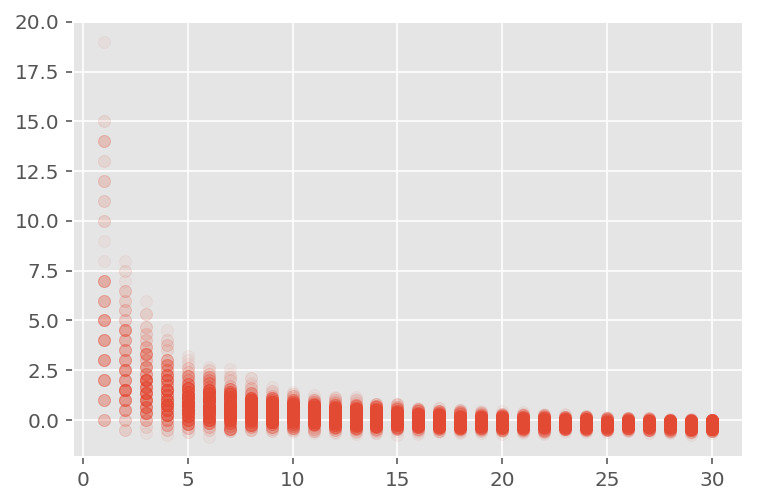

In [1419]:
plt.scatter(y_test, (y_pred-y_test)/y_test, alpha=0.05)

In [1420]:
result = pd.DataFrame(y_pred, y_test).reset_index()
result.columns=['y_test','y_pred']
result = result.sort_values(by='y_pred')
result.head(50)

,y_test,y_pred
918,2,1.0
3279,4,1.0
3226,0,1.0
4912,3,1.0
571,1,1.0
2825,1,1.0
6250,0,1.0
1031,0,1.0
1483,2,1.0
3874,1,1.0


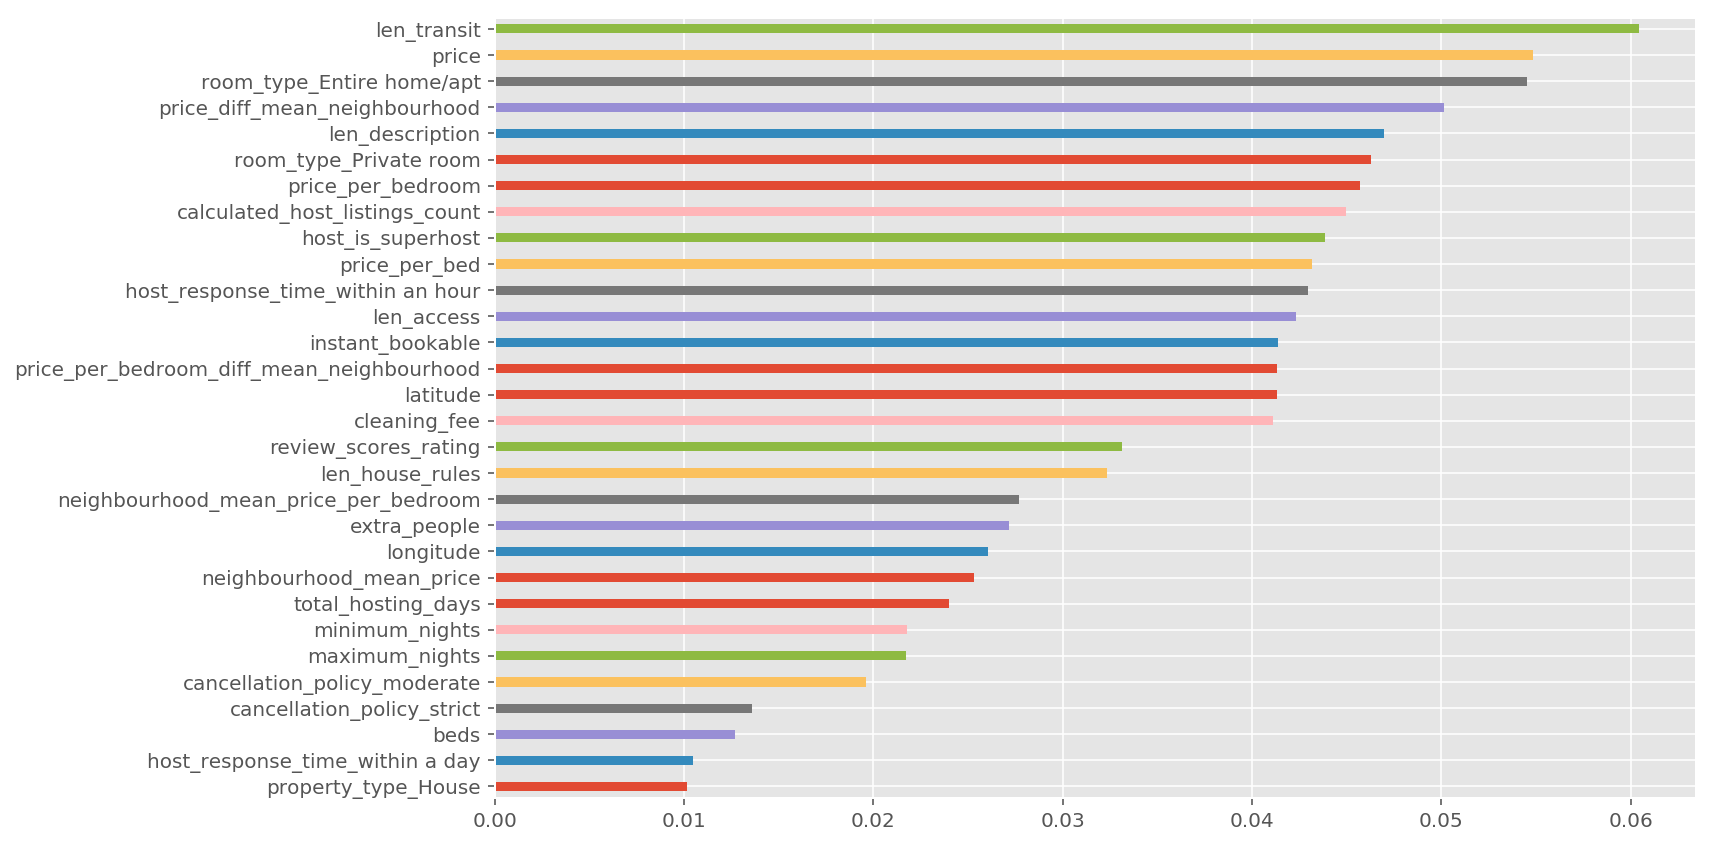

In [1421]:
neg_mae = lambda y1, y2: -mean_squared_log_error(y1, y2)
feature_importance = plot_myRf_feature_importance(X.values, y.values,scorer=neg_mae,
                                                   col_names=X.columns.tolist(),n_trees=50, show_n=30);

In [1422]:
feature_importance.iloc[:]

,Importance
Features,
len_transit,6.042439e-02
price,5.482852e-02
room_type_Entire home/apt,5.452203e-02
price_diff_mean_neighbourhood,5.013201e-02
len_description,4.695605e-02
room_type_Private room,4.630304e-02
price_per_bedroom,4.570944e-02
calculated_host_listings_count,4.495157e-02
host_is_superhost,4.383228e-02


In [756]:
X.shape

(34651, 181)

In [757]:
df_corr = X.corr()

In [758]:
show_corr('price_per_bedroom', df_corr, X, nb=10)

,Most negative corr column,Most negative corr value,Most positive corr column,Most positive corr value
0,room_type_Private room,-0.127049,price_per_bedroom,1.000000
1,last90,-0.114316,price_per_bedroom_diff_mean_neighbourhood,0.984511
2,last120,-0.113132,price_per_bed,0.966143
3,last180,-0.108769,price,0.826885
4,room_type_Shared room,-0.082978,price_diff_mean_neighbourhood,0.811051
5,host_response_time_within an hour,-0.066785,neighbourhood_mean_price_per_bedroom,0.175585
6,number_of_reviews,-0.066490,neighbourhood_mean_price,0.161239
7,property_type_House,-0.056203,room_type_Entire home/apt,0.152543
8,calculated_host_listings_count,-0.053488,cleaning_fee,0.146008
9,neighbourhood_cleansed_Outer Sunset,-0.048840,latitude,0.118475


In [759]:
X.head()

,host_is_superhost,host_identity_verified,latitude,longitude,bedrooms,beds,price,cleaning_fee,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,require_guest_phone_verification,calculated_host_listings_count,last90,last120,last180,total_hosting_days,price_per_bedroom,price_per_bed,neighbourhood_mean_price_per_bedroom,neighbourhood_mean_price,price_diff_mean_neighbourhood,price_per_bedroom_diff_mean_neighbourhood,len_house_rules,len_description,len_access,len_transit,host_response_time_a few days or more,host_response_time_unknown,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,neighbourhood_cleansed_Bayview,neighbourhood_cleansed_Bernal Heights,neighbourhood_cleansed_Castro/Upper Market,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Crocker Amazon,neighbourhood_cleansed_Diamond Heights,neighbourhood_cleansed_Downtown/Civic Center,neighbourhood_cleansed_Excelsior,neighbourhood_cleansed_Financial District,neighbourhood_cleansed_Glen Park,neighbourhood_cleansed_Golden Gate Park,neighbourhood_cleansed_Haight Ashbury,neighbourhood_cleansed_Inner Richmond,neighbourhood_cleansed_Inner Sunset,neighbourhood_cleansed_Lakeshore,neighbourhood_cleansed_Marina,neighbourhood_cleansed_Mission,neighbourhood_cleansed_Nob Hill,neighbourhood_cleansed_Noe Valley,neighbourhood_cleansed_North Beach,neighbourhood_cleansed_Ocean View,neighbourhood_cleansed_Outer Mission,neighbourhood_cleansed_Outer Richmond,neighbourhood_cleansed_Outer Sunset,neighbourhood_cleansed_Pacific Heights,neighbourhood_cleansed_Parkside,neighbourhood_cleansed_Potrero Hill,neighbourhood_cleansed_Presidio,neighbourhood_cleansed_Presidio Heights,neighbourhood_cleansed_Russian Hill,neighbourhood_cleansed_Seacliff,neighbourhood_cleansed_South of Market,neighbourhood_cleansed_Treasure Island/YBI,neighbourhood_cleansed_Twin Peaks,neighbourhood_cleansed_Visitacion Valley,neighbourhood_cleansed_West of Twin Peaks,neighbourhood_cleansed_Western Addition,property_type_Aparthotel,property_type_Apartment,property_type_Bed & Breakfast,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular,property_type_Castle,property_type_Cave,property_type_Condominium,property_type_Cottage,property_type_Dorm,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_In-law,property_type_Loft,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Tent,property_type_Timeshare,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,calendar_updated_1 week ago,calendar_updated_10 months ago,calendar_updated_11 months ago,calendar_updated_12 months ago,calendar_updated_13 months ago,calendar_updated_14 months ago,calendar_updated_15 months ago,calendar_updated_16 months ago,calendar_updated_17 months ago,calendar_updated_18 months ago,calendar_updated_19 months ago,calendar_updated_2 days ago,calendar_updated_2 months ago,calendar_updated_2 weeks ago,calendar_updated_20 months ago,calendar_updated_21 months ago,calendar_updated_22 months ago,calendar_updated_23 months ago,calendar_updated_24 months ago,calendar_updated_25 months ago,calendar_updated_26 months ago,calendar_updated_27 months ago,calendar_updated_28 months ago,calendar_updated_29 months ago,calendar_updated_3 days ago,calendar_updated_3 months ago,calendar_updated_3 weeks ago,calendar_updated_31 months ago,calendar_updated_39 months ago,calendar_updated_4 days ago,calendar_updated_4 months ago,calendar_updated_4 weeks ago,calendar_updated_43 months ago,calendar_updated_5 days ago,calendar_updated_5 months ago,calendar_updated_5 weeks ago,calendar_updated_52 months ago,calendar_updated_6 days ago,calendar_updat